## Whit this note can do? 
- collecting figures that can be used for the manuscirpt. 

In [1]:
#Pkg.add("Pkg"); import Pkg; 
using Pkg
using Distributed
using DelimitedFiles
using Distances
using StatsBase  # StatsBase.mode
using CSV
using Profile    
using Random
using Statistics
using LinearAlgebra
using KernelDensity
using Printf
using Measures
using LaTeXStrings;
using Plots
using DataFrames
using StatsPlots
rng = Random.MersenneTwister(1234);
# If I get any message related to library, try the following command.
#filter!(lib -> occursin("glib", lib), dllist())

MersenneTwister(1234)

In [2]:
const pxl2pt = 0.75;
α_gen_dbl = 83 * 0.5
α_gen_sgl = 83
α_lbl_dbl = 55.4 * 0.5
α_lbl_sgl = 55.4;
my_margin = 5mm;

In [3]:
include("../src/analysis.jl");
include("../src/basic_MPL.jl");
include("../src/my_HIV_data_cleanign.jl")
include("../src/basic_analysis.jl");
include("../src/basic.jl");
include("../src/figure.jl");
Alpha_set_temp = ["-","A","C","D","E","F","G","H","I","K","L","M","N","P","Q","R","S","T","V","W","Y", "*"];
Alpha_Dic_temp = Dict( "-"=>1,"A"=>2,"C"=>3,"D"=>4,"E"=>5,
	"F"=>6,"G"=>7,"H"=>8,"I"=>9,"K"=>10,"L"=>11,
	"M"=>12,"N"=>13,"P"=>14,"Q"=>15,"R"=>16,"S"=>17,"T"=>18,"V"=>19,"W"=>20, "Y"=>21, "*"=>22);
NUC = ["-", "A", "C", "G", "T"];
q = length(NUC);
AA_set = ["-", "A", "C", "D", "E", "F", "G", "H", "I", "K", "L", "M", "N", "P", "Q", "R", "S", "T", "V", "W", "Y", "*"];
AA2NUM = Dict(AA_set[i] => i for i in 1:length(AA_set));
q_AA = length(AA_set);

In [4]:
fname_key_human_and_RMs = ["703010505", "RM5695", "RM6070", "RM6072", "RM6697", "RM6699", "RM6701", "RM6703"];
n_RMs_max = length(fname_key_human_and_RMs)
n_len_H_RMs = length(fname_key_human_and_RMs);
csv_raw_CH505 = DataFrame(CSV.File("../out/703010505-3-poly_sorted_with_mutant.csv"));
csv_raw_RMs_merged = DataFrame(CSV.File("../out/RMs-merged-3-poly_sorted_with_mutant_CH505.csv"));

seq_raw = readdlm("../data/mpl/703010505-3-poly-seq2state.dat");
time_temp = copy(seq_raw[:,1])
time_unique = Int.(sort(unique(time_temp)));

## Making Trajecotry plots 

In [5]:
L_fig_tot = 1_200
(plot_traject, time_unique, x1_CTL, x1_CH103, x1_CH235, x1_autologous) = get_trajectory_plot_CH505(csv_raw_CH505, L_fig_tot);
(plot_selection_vs_time, time_CTL, time_CH103, time_CH235, time_autologous, 
    selection_CTL, selection_CH103, selection_CH235, selection_autologous) = get_selection_vs_time_plot_CH505(csv_raw_CH505, L_fig_tot);
(plot_violin_plot, s_res_CH103, s_res_CH235, s_res_spcfc) = get_violin_plot_CH505(csv_raw_CH505, L_fig_tot);

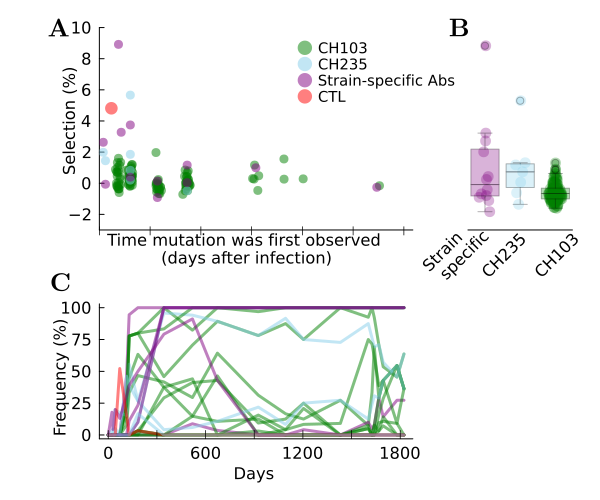

In [6]:
l = @layout [
    a{0.75w, 0.6h} b{0.25w, 0.6h}
    c{0.75w, 0.4h} _]
Plots.plot(plot_selection_vs_time, plot_violin_plot, 
            plot_traject, layout=l, size=(L_fig_tot*0.5,500))
#Plots.savefig("../fig/CH505/trajecory_selection_CH505.pdf")

In [7]:
flat_x1_CTL = [item for sublist in x1_CTL for item in sublist]
flat_time_CTL = [item for sublist in x1_CTL for item in time_unique]
flat_id_CTL = [@sprintf("CTL.%d", n) for n in 1:size(x1_CTL,1) for i in time_unique]
#
flat_x1_CH103 = [item for sublist in x1_CH103 for item in sublist]
flat_time_CH103 = [item for sublist in x1_CH103 for item in time_unique]
flat_id_CH103 = [@sprintf("CH103.%d", n) for n in 1:size(x1_CH103,1) for i in time_unique]
#
flat_x1_CH235 = [item for sublist in x1_CH235 for item in sublist]
flat_time_CH235 = [item for sublist in x1_CH235 for item in time_unique]
flat_id_CH235 = [@sprintf("CH235.%d", n) for n in 1:size(x1_CH235,1) for i in time_unique]
#
flat_x1_autologous = [item for sublist in x1_autologous for item in sublist]
flat_time_autologous = [item for sublist in x1_autologous for item in time_unique];
flat_id_autologous = [@sprintf("autologous.%d", n) for n in 1:size(x1_autologous,1) for i in time_unique];

In [8]:
# -------- Export the data for Fig3A, the selection vs time plot -------#
df = DataFrame( 
    id=[flat_id_CTL; flat_id_CH103; flat_id_CH235; flat_id_autologous], 
    time=[flat_time_CTL; flat_time_CH103; flat_time_CH235; flat_time_autologous], 
    frequency=[flat_x1_CTL; flat_x1_CH103; flat_x1_CH235; flat_x1_autologous], 
)
CSV.write("../out/for_figures/fig3C_trajectory.csv", df); 

In [9]:
df = DataFrame(
    category=[repeat(["CTL"], length(time_CTL)); repeat(["CH103"], length(time_CH103));
     repeat(["CH235"], length(time_CH235)); repeat(["autologous"], length(time_autologous))], 
    time=[time_CTL; time_CH103; time_CH235; time_autologous], 
    selection=[selection_CTL; selection_CH103; selection_CH235; selection_autologous] )
CSV.write("../out/for_figures/fig3A_selection_vs_time.csv", df); 

## Compare Fitness landscape of RMs and CH505 

In [10]:
csv_raw_CH505 = DataFrame(CSV.File("../data/mpl/SHIV.CH505_AA/703010505-poly.csv"));
poly_idx_CH505 =  DataFrame(CSV.File("../data/mpl/SHIV.CH505_AA/index-703010505.csv"));
poly_idx_RMs = DataFrame(CSV.File("../data/mpl/SHIV.CH505_AA/index-RMs-poly.csv"));

csv_raw_RMs_merged = DataFrame(CSV.File("../data/mpl/SHIV.CH505_AA/RMs-poly.csv"));
n_H_RMs = length(fname_key_human_and_RMs);

fname_dev = ["RM5695", "RM6070", "RM6072"]
marker_set_with_human = ["circle", "circle", "circle", "circle", "utriangle", "utriangle", "utriangle", "utriangle"];

## Compare fitness landscapes of CH505 and jointed SHIV.CH505

In [18]:
dir_name = "../data/mpl/SHIV.CH505_AA/"
(fitness_ind_tot_CH505_random_set, fitness_ind_tot_RMs_random_set, 
 mean_fitness_ind_tot_CH505_random_set, mean_fitness_ind_tot_RMs_random_set,     
 errorbar_tot_CH505_set, errorbar_tot_RMs_set, 
    date_unique_set, bool_BNB_nonBNB) = get_compare_fitness(fname_key_human_and_RMs, fname_dev, dir_name, 
                        csv_raw_CH505, csv_raw_RMs_merged; flag_include_HIV=false, flag_shuffle = false);



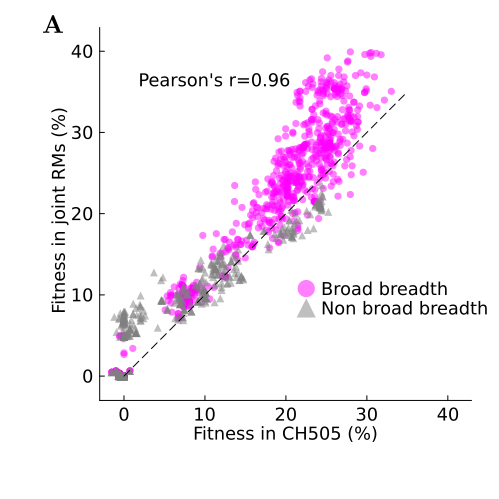

In [19]:
L_fig = 500
fontsize_reg = Int(ceil((2*L_fig)/α_gen_sgl * pxl2pt * (1.0/0.8))) # because we rescale these figures
fontsize_label_reg = Int(ceil((2*L_fig)/α_lbl_sgl * pxl2pt* (1.0/0.8)))
my_alpha = 0.5

fitness_ind_tot_CH505_random_set_vec = copy(reduce(vcat, fitness_ind_tot_CH505_random_set))
fitness_ind_tot_RMs_random_set_vec = copy(reduce(vcat, fitness_ind_tot_RMs_random_set))

max_x = maximum([maximum(fitness_ind_tot_CH505_random_set_vec), maximum(fitness_ind_tot_RMs_random_set_vec)]) + 3
p1tot = scatter(fitness_ind_tot_CH505_random_set_vec[Bool.(bool_BNB_nonBNB)], 
            fitness_ind_tot_RMs_random_set_vec[Bool.(bool_BNB_nonBNB)],
            label="Broad breadth", 
            c=:magenta, 
            alpha=my_alpha,
            foreground_color_legend = nothing,
            labelfontsize=fontsize_reg,
            xlim=(-3, max_x), 
            ylim=(-3, max_x), 
            markerstrokewidth=0,
            grid=:false,
            m = :circle,
            margin=my_margin, 
            xlabel="Fitness in CH505 (%)\n ", 
            ylabel=" \n Fitness in joint RMs (%)",
            legend=(0.6, 0.3),
            legendfontsize=fontsize_reg, 
            tickfontsize=fontsize_reg,
)
scatter!(fitness_ind_tot_CH505_random_set_vec[.!Bool.(bool_BNB_nonBNB)], 
            fitness_ind_tot_RMs_random_set_vec[.!Bool.(bool_BNB_nonBNB)],
            label="Non broad breadth", 
            c=:gray, 
            alpha=my_alpha,
            foreground_color_legend = nothing,
            labelfontsize=fontsize_reg,
            xlim=(-3, max_x), 
            ylim=(-3, max_x), 
            markerstrokewidth=0,
            legend=(0.6, 0.3),
            m =:utriangle,
)
pearson_cor = cor(fitness_ind_tot_CH505_random_set_vec, fitness_ind_tot_RMs_random_set_vec);
annotate!(2, max_x*0.85, text(@sprintf("Pearson's r=%.2f", pearson_cor), 
        fontsize_reg, :left, rotation=0, color=:black))
Plots.plot!(p1tot[1], collect(0:35), collect(0:35), sybplot=1, c="black", linestyle=:dash, label=:false)
annotate!(-10, max_x*1.01, text(L"\textbf{A}", :left, fontsize_label_reg))

Plots.plot(p1tot, size=(L_fig, L_fig))


In [20]:
# -------- Export the data for Fig4A, comparison of CH505 and jointed RMs fitness landscapes  -------#
df = DataFrame( F_CH505 = fitness_ind_tot_CH505_random_set_vec,
                F_jointedRMs = fitness_ind_tot_RMs_random_set_vec,
                breadth = bool_BNB_nonBNB )
CSV.write("../out/for_figures/fig4A_fitness_comparison.csv", df); 

### Shuffled sequences 

In [21]:
dir_name = "../data/mpl/SHIV.CH505_AA/"
(fitness_ind_tot_CH505_shuffle_set, fitness_ind_tot_RMs_shuffle_set, 
 mean_fitness_ind_tot_CH505_shuffle_set, mean_fitness_ind_tot_RMs_shuffle_set,     
 errorbar_tot_CH505_shuffle_set, errorbar_tot_RMs_shuffle_set, 
    date_unique_set_shuffle, bool_BNB_nonBNB_shuffle) = get_compare_fitness(fname_key_human_and_RMs, fname_dev, dir_name, 
                        csv_raw_CH505, csv_raw_RMs_merged; flag_include_HIV=false, flag_shuffle = true);

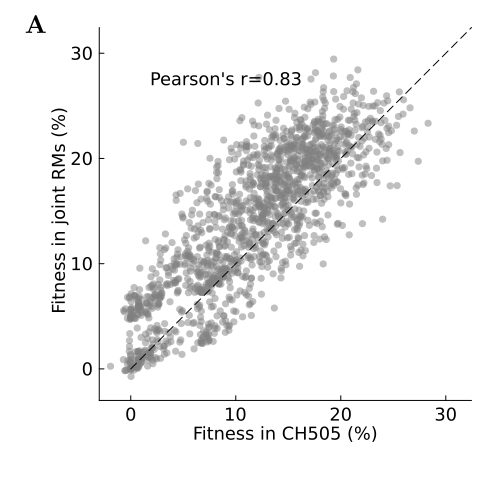

In [22]:
L_fig = 500
fontsize_reg = Int(ceil((2*L_fig)/α_gen_sgl * pxl2pt * (1.0/0.8))) # because we rescale these figures
fontsize_label_reg = Int(ceil((2*L_fig)/α_lbl_sgl * pxl2pt* (1.0/0.8)))
my_alpha = 0.5

fitness_ind_tot_CH505_shuffle_set_vec = copy(reduce(vcat, fitness_ind_tot_CH505_shuffle_set))
fitness_ind_tot_RMs_shuffle_set_vec = copy(reduce(vcat, fitness_ind_tot_RMs_shuffle_set))

max_x = maximum([maximum(fitness_ind_tot_CH505_shuffle_set_vec), maximum(fitness_ind_tot_RMs_shuffle_set_vec)]) + 3
p1tot = scatter(fitness_ind_tot_CH505_shuffle_set_vec[Bool.(bool_BNB_nonBNB_shuffle)], 
            fitness_ind_tot_RMs_shuffle_set_vec[Bool.(bool_BNB_nonBNB_shuffle)],
            legend=:false,
            c=:gray, 
            alpha=my_alpha,
            foreground_color_legend = nothing,
            labelfontsize=fontsize_reg,
            xlim=(-3, max_x), 
            ylim=(-3, max_x), 
            markerstrokewidth=0,
            grid=:false,
            m = :circle,
            margin=my_margin, 
            xlabel="Fitness in CH505 (%)\n ", 
            ylabel=" \n Fitness in joint RMs (%)",
            legendfontsize=fontsize_reg, 
            tickfontsize=fontsize_reg,
)
scatter!(fitness_ind_tot_CH505_shuffle_set_vec[.!Bool.(bool_BNB_nonBNB_shuffle)], 
            fitness_ind_tot_RMs_shuffle_set_vec[.!Bool.(bool_BNB_nonBNB_shuffle)],
            legend=:false,
            c=:gray, 
            alpha=my_alpha,
            foreground_color_legend = nothing,
            labelfontsize=fontsize_reg,
            xlim=(-3, max_x), 
            ylim=(-3, max_x), 
            markerstrokewidth=0,
            m =:circle,
)
pearson_cor = cor(fitness_ind_tot_CH505_shuffle_set_vec, fitness_ind_tot_RMs_shuffle_set_vec);
annotate!(2, max_x*0.85, text(@sprintf("Pearson's r=%.2f", pearson_cor), 
        fontsize_reg, :left, rotation=0, color=:black))
Plots.plot!(p1tot[1], collect(0:35), collect(0:35), sybplot=1, c="black", linestyle=:dash, label=:false)
annotate!(-10, max_x*1.01, text(L"\textbf{A}", :left, fontsize_label_reg))

Plots.plot(p1tot, size=(L_fig, L_fig))


In [23]:
# -------- Export the data for Fig4A, comparison of CH505 and jointed RMs fitness landscapes  -------#
df = DataFrame( F_CH505 = fitness_ind_tot_CH505_shuffle_set_vec,
                F_jointedRMs = fitness_ind_tot_RMs_shuffle_set_vec,
                breadth = bool_BNB_nonBNB_shuffle )
CSV.write("../out/for_figures/figS3A_fitness_comparison_using_shuffled_seq.csv", df); 

## Fitness change Plots 

α_dev=0.192 α_undev=0.062 


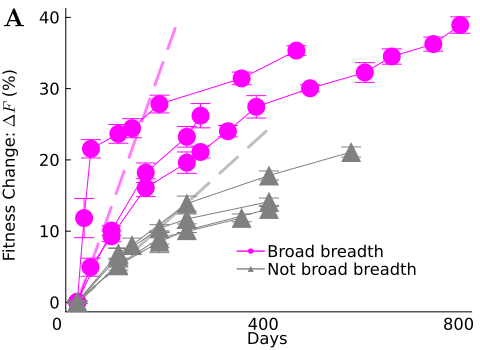

In [24]:
# This figure would be double column
n_H_RMs = length(fname_key_human_and_RMs)
k = 1
L_fig_tot = 1200
L_fig = Int(0.4*L_fig_tot)
fontsize_reg = Int(ceil(L_fig_tot/α_gen_sgl * pxl2pt))
fontsize_label_reg = Int(ceil(L_fig_tot/α_lbl_sgl * pxl2pt))

my_ms = 10
α_lin_dev = linreg(date_unique_set[k][1:4], mean_fitness_ind_tot_RMs_random_set[k][1:4])
for k_temp in 2:3 α_lin_dev += linreg(date_unique_set[k_temp][1:4], mean_fitness_ind_tot_RMs_random_set[k_temp][1:4]) end

α_lin_undev = linreg(date_unique_set[4][1:3], mean_fitness_ind_tot_RMs_random_set[4][1:3])
for k_temp in 5:7 α_lin_undev += linreg(date_unique_set[k_temp][1:3], mean_fitness_ind_tot_RMs_random_set[k_temp][1:3]) end

α_lin_dev /= 3; α_lin_undev /= 4
@printf("α_dev=%.3f α_undev=%.3f \n", α_lin_dev, α_lin_undev)

p = Plots.plot(collect(0:100:250), α_lin_dev*collect(0:100:250), linestyle=:dash, c=:magenta, label=:false, lw=3, alpha=0.5)
Plots.plot!(collect(0:100:400), α_lin_undev*collect(0:100:400), linestyle=:dash, c=:gray, label=:false, lw=3, alpha=0.5)

plot!(date_unique_set[k], mean_fitness_ind_tot_RMs_random_set[k], 
#    m=Symbol(marker_set_with_human[k]), label=fname_key_human_and_RMs[k],     
    m=Symbol(marker_set_with_human[k+1]), label="Broad breadth",
    yerror=errorbar_tot_RMs_set[k],
    markerstrokecolor="magenta",
    c="magenta",
    size=(L_fig,Int(350)),
    foreground_color_legend = nothing,
    labelfontsize=fontsize_reg,
    grid=:false,
    margin=0.1mm, 
    ms=my_ms,
    xlabel=" \n ", 
    ylabel=" \n ", 
    xticks=:false,
#    xlim=(-10, 900),
    legend=(0.5, 0.2),
#    legend=:false,
    legendfontsize=fontsize_reg, 
    tickfontsize=fontsize_reg,
)
annotate!(-140, 6, text(L"Fitness Change: $ΔF$ (%)", fontsize_reg, :left, rotation=90))
annotate!(350, -5, text("Days", fontsize_reg, :left))
[annotate!(i-50, -3, text(string(i), fontsize_reg, :left)) for i in [0, 400, 800]]

for k in 2:(n_H_RMs-1)
    key_RM = fname_key_human_and_RMs[k+1]
    this_c = "gray"
    if(key_RM ∈ fname_dev) this_c = "magenta" end
#    if(key_RM == "RM6072") this_c = "pink" end
    if(k==4)
        plot!(p[1], date_unique_set[k], mean_fitness_ind_tot_RMs_random_set[k], ms=my_ms,
            yerror=errorbar_tot_RMs_set[k], markerstrokecolor=this_c,
            sbuplot=1, m=Symbol(marker_set_with_human[k+1]), label="Not broad breadth", c=this_c)
    end
    if(k!=4)
        plot!(p[1], date_unique_set[k], mean_fitness_ind_tot_RMs_random_set[k], ms=my_ms,
            yerror=errorbar_tot_RMs_set[k], markerstrokecolor=this_c,
            sbuplot=1, m=Symbol(marker_set_with_human[k+1]), label=:false, c=this_c)
    end
end
#display(p);
annotate!(-150, 40, text(L"\textbf{A}", :left, fontsize_label_reg))
#Plots.savefig("../fig/CH505/fitness_change_mutations_left_fig.pdf")

In [53]:
RM_id = [@sprintf("RM%d", k) for k in 1:size(date_unique_set,1) for _ in date_unique_set[k]]
breadth = [x ∈ ["RM1", "RM2", "RM3"]  for x in RM_id ]
date = [item for sublist in date_unique_set for item in sublist]
mean_F = [item for sublist in mean_fitness_ind_tot_RMs_random_set for item in sublist]
std_F = [item for sublist in errorbar_tot_RMs_set for item in sublist];
"""
df = DataFrame( 
RM_id = RM_id,
# Suppose RMs 1-3 have broad breadth 

#CSV.write("../out/for_figures/fig6A_fitness_change.csv", df); 
""";

In [54]:
# --- Adding CH505's data --- #
dir_name = "../data/mpl/SHIV.CH505_AA/"
(fitness_ind_tot_CH505_random_set, fitness_ind_tot_RMs_random_set, 
 mean_fitness_ind_tot_CH505_random_set, mean_fitness_ind_tot_RMs_random_set,     
 errorbar_tot_CH505_set, errorbar_tot_RMs_set, 
    date_unique_set, bool_BNB_nonBNB) = get_compare_fitness(fname_key_human_and_RMs, fname_dev, dir_name, 
                        csv_raw_CH505, csv_raw_RMs_merged; flag_include_HIV=true, flag_shuffle = false);

In [ ]:
RM_id = [copy(RM_id); ["CH505" for _ in date_unique_set[1]]]    
breadth = [copy(breadth); [true for _ in date_unique_set[1]]]
date = [copy(date); date_unique_set[1]]
mean_F = [copy(mean_F); mean_fitness_ind_tot_CH505_random_set[1]]
std_F = [copy(std_F); errorbar_tot_CH505_set[1]];

df = DataFrame(
    RM_id = RM_id,
    breadth = breadth,
    date = date,
    mean_F = mean_F,
    std_F = std_F
)   
CSV.write("../out/for_figures/fig6A_fitness_change.csv", df);

## Including HIV sequences for projection onto the jont RMs fitness landscape.

In [57]:
"""
dir_name = "../data/mpl/SHIV.CH505_AA/"
(fitness_ind_tot_CH505_random_set, fitness_ind_tot_RMs_random_set, 
 mean_fitness_ind_tot_CH505_random_set, mean_fitness_ind_tot_RMs_random_set,     
 errorbar_tot_CH505_set, errorbar_tot_RMs_set, 
    date_unique_set, bool_BNB_nonBNB) = get_compare_fitness(fname_key_human_and_RMs, fname_dev, dir_name, 
                        csv_raw_CH505, csv_raw_RMs_merged; flag_include_HIV=true, flag_shuffle = false);
""";

In [56]:
"""
# This figure would be double column
n_H_RMs = length(fname_key_human_and_RMs)
L_fig_tot = 1200
L_fig = Int(0.4*L_fig_tot)
fontsize_reg = Int(ceil(L_fig_tot/α_gen_sgl * pxl2pt))
fontsize_label_reg = Int(ceil(L_fig_tot/α_lbl_sgl * pxl2pt))

my_ms = 10
k = 2
α_lin_dev = linreg(date_unique_set[k][1:4], mean_fitness_ind_tot_RMs_random_set[k][1:4])
for k_temp in 3:4 α_lin_dev += linreg(date_unique_set[k_temp][1:4], mean_fitness_ind_tot_RMs_random_set[k_temp][1:4]) end
k = 5
α_lin_undev = linreg(date_unique_set[5][1:3], mean_fitness_ind_tot_RMs_random_set[5][1:3])
for k_temp in 6:8 α_lin_undev += linreg(date_unique_set[k_temp][1:3], mean_fitness_ind_tot_RMs_random_set[k_temp][1:3]) end

α_lin_dev /= 3; α_lin_undev /= 4
@printf("α_dev=%.3f α_undev=%.3f \n", α_lin_dev, α_lin_undev)

p = Plots.plot(collect(0:100:250), α_lin_dev*collect(0:100:250), linestyle=:dash, c=:magenta, label=:false, lw=3, alpha=0.5)
Plots.plot!(collect(0:100:400), α_lin_undev*collect(0:100:400), linestyle=:dash, c=:gray, label=:false, lw=3, alpha=0.5)

common_plot_params = Dict(
    :m => Symbol(marker_set_with_human[k+1]),
    :label => "Broad breadth",
    :yerror => errorbar_tot_RMs_set[k],
    :markerstrokecolor => "magenta",
    :c => "magenta",
    :size => (L_fig,Int(350)),
    :foreground_color_legend => nothing,
    :labelfontsize => fontsize_reg,
    :grid => :false,
    :margin => 0.1mm,
    :ms => my_ms,
    :xlabel => " \n ",
    :ylabel => " \n ",
    :xticks => :false
)

k = 1
#plot!(date_unique_set[k], mean_fitness_ind_tot_RMs_random_set[k], 
plot!(date_unique_set[k], mean_fitness_ind_tot_CH505_random_set[k], 
#    m=Symbol(marker_set_with_human[k]), label=fname_key_human_and_RMs[k],     
    m=Symbol(marker_set_with_human[k+1]), label="CH505",
    yerror=errorbar_tot_RMs_set[k],
    markerstrokecolor="red",
    c="red",
    size=(L_fig,Int(350)),
    foreground_color_legend = nothing,
    labelfontsize=fontsize_reg,
    grid=:false,
    margin=0.1mm, 
    ms=my_ms,
    xlabel=" \n ", 
    ylabel=" \n ", 
    xticks=:false,
    #xlim=(-10, 900),
    legend=(0.5, 0.2),
#    legend=:false,
    legendfontsize=fontsize_reg, 
    tickfontsize=fontsize_reg,
)
annotate!(-250, 6, text(L"Fitness Change: $ΔF$ (%)", fontsize_reg, :left, rotation=90))
annotate!(350, -5, text("Days", fontsize_reg, :left))
[annotate!(i-50, -3, text(string(i), fontsize_reg, :left)) for i in [0, 400, 800]]

for k in 2:n_H_RMs
    key_RM = fname_key_human_and_RMs[k]
    this_c = "gray"
    if(key_RM ∈ fname_dev) this_c = "magenta" end
    if(key_RM == "RM5695")
        plot!(p[1], date_unique_set[k], mean_fitness_ind_tot_RMs_random_set[k], ms=my_ms,
            yerror=errorbar_tot_RMs_set[k], markerstrokecolor=this_c,
            sbuplot=1, m=Symbol(marker_set_with_human[k]), label="Broad breadth", c=this_c)
    end    
    if(key_RM == "RM6697")
        plot!(p[1], date_unique_set[k], mean_fitness_ind_tot_RMs_random_set[k], ms=my_ms,
            yerror=errorbar_tot_RMs_set[k], markerstrokecolor=this_c,
            sbuplot=1, m=Symbol(marker_set_with_human[k]), label="Not broad breadth", c=this_c)
    end
    if(key_RM ∉ ["RM5695", "RM6697"])
        plot!(p[1], date_unique_set[k], mean_fitness_ind_tot_RMs_random_set[k], ms=my_ms,
            yerror=errorbar_tot_RMs_set[k], markerstrokecolor=this_c,
            sbuplot=1, m=Symbol(marker_set_with_human[k]), label=:false, c=this_c)
    end
end
#display(p);
#annotate!(-150, 40, text(L"\textbf{A}", :left, fontsize_label_reg))
Plots.savefig("../fig/fitness_change_mutations_left_fig_w_CH505.pdf")
""";

ErrorException: syntax: invalid interpolation syntax: "$ "

## Characterize RMs developed bnAbs and ddn't develop bnAbs  

In [46]:
dir_name = "../data/mpl/SHIV.CH505_AA/"
L_fig_tot = 1200# 3600
(plot_selected_heatmap, heatmap_BNB_or_nonBNB, mutation_names_BNB_or_nonBNB, heatmap_only_BNB, mutation_names_only_BNB) = get_heatmap_selected_mutations_CH505(dir_name, L_fig_tot);


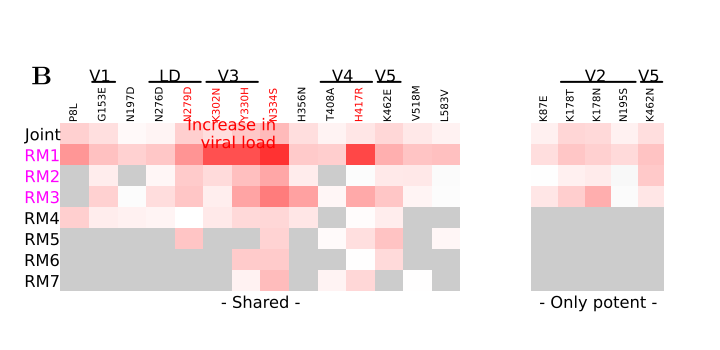

In [47]:
plot_selected_heatmap

In [48]:
flat_mat_value = []
category_name = []
model_name = []
mutation_name = []
location_name = []
model_name_list = reverse(["jointed_RMs"; [@sprintf("RM%d", i) for i in 1:7]])
for i in 1:size(heatmap_BNB_or_nonBNB, 1)
    for j in 1:size(heatmap_BNB_or_nonBNB, 2)
        push!(model_name, model_name_list[i])
        mut_name_temp = mutation_names_BNB_or_nonBNB[j]
        push!(mutation_name, mut_name_temp)
        push!(category_name, "BNB_or_nonBNB")
        if(isnothing(get_variable_regions(extract_integer(mut_name_temp))))
            push!(location_name, "NaN")
        else
            push!(location_name, get_variable_regions(extract_integer(mut_name_temp)))
        end
            
        if(heatmap_BNB_or_nonBNB[i,j]>-0.09)
            push!(flat_mat_value, heatmap_BNB_or_nonBNB[i,j])
        else
            push!(flat_mat_value, "NaN")
        end
    end
end
for i in 1:size(heatmap_only_BNB, 1)
    for j in 1:size(heatmap_only_BNB, 2)
        push!(model_name, model_name_list[i])
        mut_name_temp = mutation_names_only_BNB[j]
        push!(mutation_name, mut_name_temp)
        push!(category_name, "only_BNB")
        if(isnothing(get_variable_regions(extract_integer(mut_name_temp))))
            push!(location_name, "NaN")
        else
            push!(location_name, get_variable_regions(extract_integer(mut_name_temp)))
        end
        if(heatmap_only_BNB[i,j]>-0.09)
            push!(flat_mat_value, heatmap_only_BNB[i,j])
        else
            push!(flat_mat_value, "NaN")
        end
    end
end
        

In [49]:
df = DataFrame(
    category = category_name, 
    model = model_name,
    mutation = mutation_name,
    location = location_name,
    selection = flat_mat_value
);
CSV.write("../out/for_figures/fig6B_selected_mutations.csv", df);

## Compare correlation of fitness landscapes among the all subjects

In [50]:
# ------------ Get heatmap of the Pearson's r matrix ------------#
L_fig = 500
n_rand_max=10
dir_name = "../data/mpl/SHIV.CH505_AA/"
fname_key_in = "703010505"
title_fig = "SHIV.CH505"
#fname_key_human_and_RMs
(p_out, cor_mat_smry, cor_mat_smry_std) = get_correlation_sumamry(fname_key_human_and_RMs, dir_name, title_fig, fname_key_in, L_fig, n_rand_max);


In [51]:
cor_mean_set = []; cor_std_set = []
model1_set = []; model2_set = []
model_name_list = [["CH505", "jointed_RMs"]; [@sprintf("RM%d", i) for i in 1:7]]
for i in 1:size(cor_mat_smry,1)
    for j in (i+1):size(cor_mat_smry,2)
        push!(cor_mean_set, cor_mat_smry[i,j])
        push!(cor_std_set, cor_mat_smry_std[i,j])
        push!(model1_set, model_name_list[i])
        push!(model2_set, model_name_list[j])
    end
end;

# ------- Export the data for Fig.S5A, Pearson's r matrix   -------#
df = DataFrame(
    model1=model1_set, 
    model2=model2_set, 
    r_mean=cor_mean_set, 
    r_std=cor_std_set
)
CSV.write("../out/for_figures/figS5A_pearson_mat.csv", df); 

## Comapre time when detected and selection coefficinet

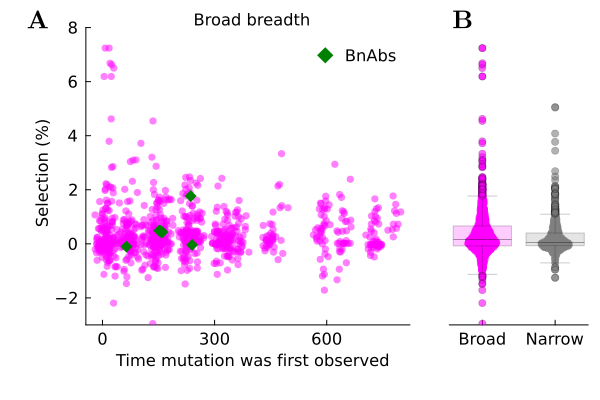

In [52]:
# -------- Make Selection vs time plot for SHIV dsata ---------#
dir_name= "../data/mpl/SHIV.CH505_AA/"
L_fig_tot = 1200
(p1, p_violin, s_BNB_set, date_BNB_set, s_notBNB_set, date_notBNB_set, date_bnAbs_RMs, s_bnAbs_RMs) = get_selection_vs_time_SHIV505(dir_name, L_fig_tot);

l = @layout[a{0.7w} b{0.3w}]
Plots.plot(p1,p_violin, layout=l, size=(L_fig_tot*0.5, 400))
#Plots.savefig("../fig/CH505/Selection_vs_time_RMs_CH505.pdf")

In [53]:
df = DataFrame(
    model = [repeat(["BNB"], length([date_BNB_set; date_bnAbs_RMs])); 
            repeat(["nonBNB"], length(date_notBNB_set))],
    date = [date_BNB_set; date_bnAbs_RMs; date_notBNB_set],
    selection = [s_BNB_set; s_bnAbs_RMs; s_notBNB_set],
    bnAbs = [[false for _ in 1:length(s_BNB_set)]; 
     [true for _ in 1:length(s_bnAbs_RMs)];
     [false for _ in 1:length(s_notBNB_set)]])
CSV.write("../out/for_figures/fig5AB_selection_vs_time_SHIV.csv", df); 